<a href="https://colab.research.google.com/github/mjgpinheiro/Econophysics/blob/main/Modified_BS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

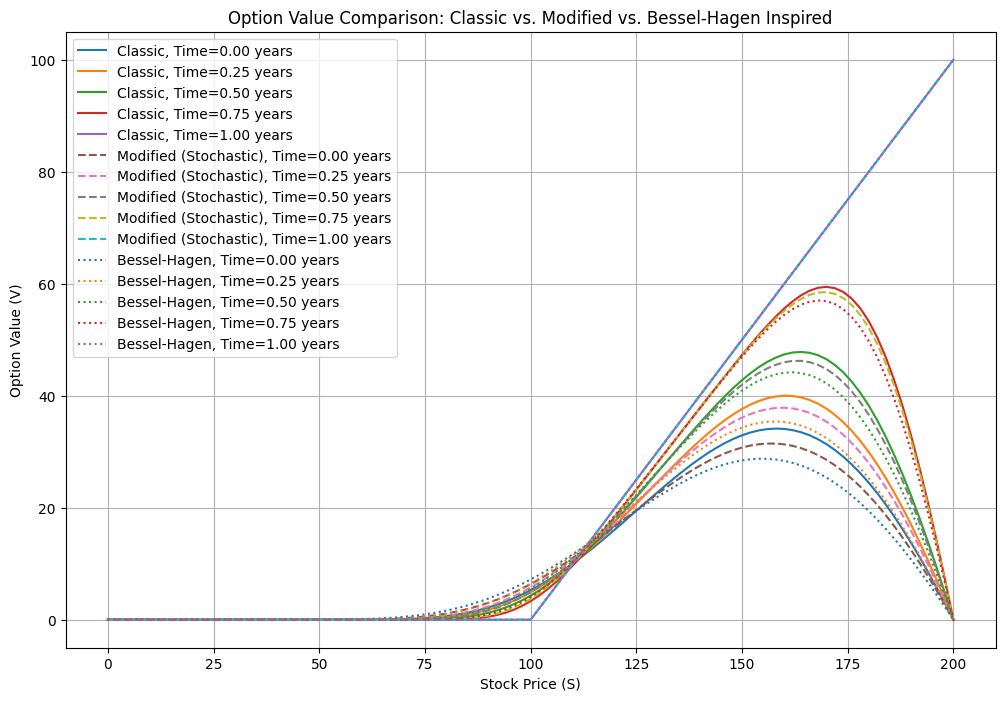

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

# Define parameters for the Black-Scholes equation
S_max = 200  # Maximum stock price
S_min = 0    # Minimum stock price
T = 1        # Time to maturity in years
N = 100      # Number of time steps
M = 100      # Number of stock price steps

r = 0.05     # Risk-free rate
sigma = 0.2  # Volatility
K = 100      # Strike price

# Define grid spacing
dt = T / N
dS = (S_max - S_min) / M
S = np.linspace(S_min, S_max, M + 1)

# Payoff function for European Call Option
payoff = np.maximum(S - K, 0)

# Initialize option value grid for classic Black-Scholes
V = np.zeros((M + 1, N + 1))
V[:, -1] = payoff  # Terminal condition

# Coefficients for the finite difference scheme (Crank-Nicolson)
j = np.arange(1, M)
alpha = 0.25 * dt * ((sigma**2) * j**2 - r * j)
beta = -0.5 * dt * ((sigma**2) * j**2 + r)
gamma = 0.25 * dt * ((sigma**2) * j**2 + r * j)

# Create tridiagonal matrix components for classic Black-Scholes
A = np.zeros((3, M - 1))
B = np.zeros((3, M - 1))

A[0, 1:] = -alpha[:-1]
A[1, :] = 1 - beta
A[2, :-1] = -gamma[1:]

B[0, 1:] = alpha[:-1]
B[1, :] = 1 + beta
B[2, :-1] = gamma[1:]

# Time-stepping for classic Black-Scholes
for n in reversed(range(N)):
    b = np.zeros(M - 1)  # Initialize RHS vector

    # Main diagonal contribution
    b += B[1, :] * V[1:M, n + 1]

    # Upper diagonal contribution
    upper_diag = B[0, 1:] * V[2:M, n + 1]
    b[:-1] += upper_diag

    # Lower diagonal contribution
    lower_diag = B[2, :-1] * V[1:M-1, n + 1]
    b[1:] += lower_diag

    # Solve tridiagonal system
    V[1:M, n] = solve_banded((1, 1), A, b)

# Define stochastic volatility as a function of S and t
def sigma_stochastic(S, t):
    return 0.2 + 0.05 * np.sin(np.pi * S / S_max) * np.exp(-t)

# Initialize option value grid for modified equation
V_modified = np.zeros((M + 1, N + 1))
V_modified[:, -1] = payoff  # Terminal condition

# Time-stepping for modified Black-Scholes
for n in reversed(range(N)):
    b = np.zeros(M - 1)  # Initialize RHS vector for modified equation

    # Update volatility based on S and t for this time step
    sigma_t = sigma_stochastic(S[1:M], n * dt)

    # Recalculate coefficients based on stochastic volatility
    alpha = 0.25 * dt * ((sigma_t**2) * j**2 - r * j)
    beta = -0.5 * dt * ((sigma_t**2) * j**2 + r)
    gamma = 0.25 * dt * ((sigma_t**2) * j**2 + r * j)

    # Update tridiagonal matrices A and B
    A[0, 1:] = -alpha[:-1]
    A[1, :] = 1 - beta
    A[2, :-1] = -gamma[1:]

    B[0, 1:] = alpha[:-1]
    B[1, :] = 1 + beta
    B[2, :-1] = gamma[1:]

    # Main diagonal contribution
    b += B[1, :] * V_modified[1:M, n + 1]

    # Upper diagonal contribution
    upper_diag = B[0, 1:] * V_modified[2:M, n + 1]
    b[:-1] += upper_diag

    # Lower diagonal contribution
    lower_diag = B[2, :-1] * V_modified[1:M-1, n + 1]
    b[1:] += lower_diag

    # Solve tridiagonal system for this time step
    V_modified[1:M, n] = solve_banded((1, 1), A, b)

# Define the additional symmetry-based term mu(S, t)
def mu_symmetry(S, t):
    return 0.01 * S * np.exp(-t)

# Initialize option value grid for the Bessel-Hagen-inspired equation
V_bessel_hagen = np.zeros((M + 1, N + 1))
V_bessel_hagen[:, -1] = payoff  # Terminal condition

# Time-stepping for the Bessel-Hagen-inspired equation
for n in reversed(range(N)):
    b = np.zeros(M - 1)  # Initialize RHS vector for the modified equation

    # Update volatility and symmetry term based on S and t
    sigma_t = sigma_stochastic(S[1:M], n * dt)  # Stochastic volatility
    mu_t = mu_symmetry(S[2:M-1], n * dt)        # Symmetry-based term for aligned length

    # Recalculate coefficients based on stochastic volatility
    alpha = 0.25 * dt * ((sigma_t**2) * j**2 - r * j)
    beta = -0.5 * dt * ((sigma_t**2) * j**2 + r)
    gamma = 0.25 * dt * ((sigma_t**2) * j**2 + r * j)

    # Update tridiagonal matrices A and B
    A[0, 1:] = -alpha[:-1]
    A[1, :] = 1 - beta
    A[2, :-1] = -gamma[1:]

    B[0, 1:] = alpha[:-1]
    B[1, :] = 1 + beta
    B[2, :-1] = gamma[1:]

    # Main diagonal contribution
    b += B[1, :] * V_bessel_hagen[1:M, n + 1]

    # Upper diagonal contribution
    upper_diag = B[0, 1:] * V_bessel_hagen[2:M, n + 1]
    b[:-1] += upper_diag

    # Lower diagonal contribution
    lower_diag = B[2, :-1] * V_bessel_hagen[1:M-1, n + 1]
    b[1:] += lower_diag

    # Add the symmetry-based term (third derivative approximation, dimensions aligned)
    symmetry_term = mu_t * (V_bessel_hagen[3:M, n + 1] - 2 * V_bessel_hagen[2:M-1, n + 1] + V_bessel_hagen[1:M-2, n + 1]) / (dS**2)
    b[1:-1] += symmetry_term  # Ensure the length aligns with b[1:-1]

    # Solve tridiagonal system for this time step
    V_bessel_hagen[1:M, n] = solve_banded((1, 1), A, b)

# Visualization of all results
plt.figure(figsize=(12, 8))

# Plot for classic Black-Scholes equation
for t_idx in range(0, N + 1, N // 4):
    plt.plot(S, V[:, t_idx], label=f'Classic, Time={t_idx * dt:.2f} years')

# Plot for modified Black-Scholes with stochastic volatility
for t_idx in range(0, N + 1, N // 4):
    plt.plot(S, V_modified[:, t_idx], linestyle='--', label=f'Modified (Stochastic), Time={t_idx * dt:.2f} years')

# Plot for Bessel-Hagen-inspired equation
for t_idx in range(0, N + 1, N // 4):
    plt.plot(S, V_bessel_hagen[:, t_idx], linestyle=':', label=f'Bessel-Hagen, Time={t_idx * dt:.2f} years')

plt.title('Option Value Comparison: Classic vs. Modified vs. Bessel-Hagen Inspired')
plt.xlabel('Stock Price (S)')
plt.ylabel('Option Value (V)')
plt.legend()
plt.grid(True)
plt.show()
